# U-Net Seismic Sweep

## Load necessary packages

In [1]:
import random
import os
import sys
import warnings

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
import scipy

### Test for GPU

In [2]:
print(f'TensorFlow Version:',tf.__version__)
print(tf.config.list_physical_devices())

TensorFlow Version: 2.7.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Set Parameters

In [3]:
#Parameters used in U-net:
IMG_WIDTH = 128
IMG_HEIGHT = 256
IMG_CHANNELS = 1

TRAINX_PATH = '/Users/samtu/Documents/XDataTrain/'
TRAINY_PATH = '/Users/samtu/Documents/YDataTrain/'
TESTX_PATH = '/Users/samtu/Documents/XDataTest/'
TESTY_PATH = '/Users/samtu/Documents/YDataTest/'
FINAL_TEST_PATH = '../input/stage2_test_final/'

dir_path = ''

dropout = 0.2

seed = 1
random.seed = seed
np.random.seed = seed

## Load Synthetic Data

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAINX_PATH))[2]
test_ids = next(os.walk(TESTX_PATH))[2]
# final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting training images ... ')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAINX_PATH + id_
    img = genfromtxt(path, delimiter=',')
    
    #Make into 3 Channels
    temp = np.array([img])
    img = temp.reshape(IMG_HEIGHT,IMG_WIDTH,1)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
    
    id_ = id_.replace('X','Y')
    path = TRAINY_PATH + id_
    mask = genfromtxt(path, delimiter=',')
    
    temp = np.array([mask])
    mask = temp.reshape(IMG_HEIGHT,IMG_WIDTH,1)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask

    

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1))
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1))
sizes_test = []

print('Getting test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TESTX_PATH + id_
    
    #Read image files iteratively
    img = genfromtxt(path, delimiter=',')
    
    #Make into 3 Channels
    temp = np.array([img])
    img = temp.reshape(IMG_HEIGHT,IMG_WIDTH,1)
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Append image to numpy array for test dataset
    X_test[n] = img
    
    
    #Y_test data:
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
    
    id_ = id_.replace('X','Y')
    path = TESTY_PATH + id_
    mask = genfromtxt(path, delimiter=',')
    
    temp = np.array([mask])
    mask = temp.reshape(IMG_HEIGHT,IMG_WIDTH,1)
    
    #Append mask to numpy array for train dataset
    Y_test[n] = mask

print('Done!')

Getting training images ... 


100%|██████████| 5000/5000 [03:03<00:00, 27.30it/s]

Getting test images ... 



100%|██████████| 100/100 [00:03<00:00, 26.04it/s]

Done!


## Visualize imported data

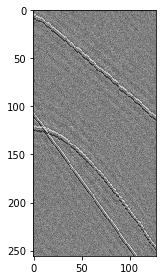

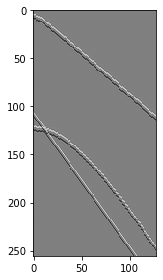

(5000, 256, 128, 1)
(5000, 256, 128, 1)


In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids)-1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
print(X_train.shape)
print(Y_train.shape)


## Build Neural Net

In [7]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [8]:
def build_model(input_layer, start_neurons):
    
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = Dropout(dropout) (conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Dropout(dropout) (conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Dropout(dropout) (conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Dropout(dropout) (conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Dropout(dropout) (uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Dropout(dropout) (uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Dropout(dropout) (uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Dropout(dropout) (uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same")(uconv1)
    
    return output_layer

input_layer = Input((IMG_HEIGHT, IMG_WIDTH, 1))
output_layer = build_model(input_layer, 16)

In [9]:
model = Model(input_layer, output_layer)
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_absolute_percentage_error"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [10]:
# model = Model(inputs=[inputs], 
#               outputs=[outputs])
# model.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])
# model.summary()

## Fitting the Model

In [11]:
earlystopper = EarlyStopping(patience=15, 
                             verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', 
                               verbose=1, 
                               save_best_only=True)

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.1, 
                    batch_size=4, 
                    epochs=10, 
                    callbacks=[earlystopper, checkpointer]
                   )

Epoch 1/10
1125/1125 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_percentage_error: 921.2993
Epoch 00001: val_loss improved from inf to 0.00064, saving model to model_unet_checkpoint.h5
1125/1125 [==============================] - 43s 31ms/step - loss: 0.0051 - mean_absolute_percentage_error: 921.2993 - val_loss: 6.3554e-04 - val_mean_absolute_percentage_error: 428.5580
Epoch 2/10
1125/1125 [==============================] - ETA: 0s - loss: 6.1341e-04 - mean_absolute_percentage_error: 625.1414
Epoch 00002: val_loss did not improve from 0.00064
1125/1125 [==============================] - 34s 31ms/step - loss: 6.1341e-04 - mean_absolute_percentage_error: 625.1414 - val_loss: 7.4760e-04 - val_mean_absolute_percentage_error: 421.9074
Epoch 3/10
1125/1125 [==============================] - ETA: 0s - loss: 4.5956e-04 - mean_absolute_percentage_error: 623.4500
Epoch 00003: val_loss improved from 0.00064 to 0.00049, saving model to model_unet_checkpoint.h5
1125/11

## Plotting the progression

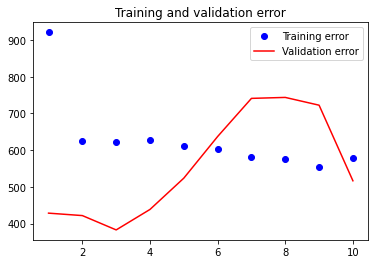

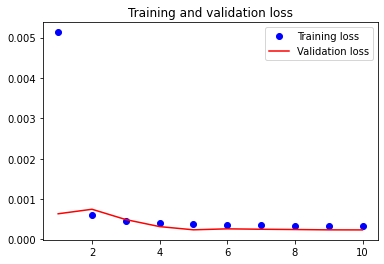

In [12]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
acc = history.history['mean_absolute_percentage_error']
val_acc = history.history['val_mean_absolute_percentage_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training error')
plt.plot(epochs, val_acc, 'r', label='Validation error')
plt.title('Training and validation error')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from numpy import savetxt
# savetxt("Loss3" + '.txt',loss, delimiter=',')
# savetxt("ValLoss3" + '.txt',val_loss, delimiter=',')

# Make Predictions

In [14]:
#Delete variable to save memory
del X_train
del Y_train

# Predict on train, val and test
model = load_model('model_unet_checkpoint.h5')
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


4/4 [==============================] - 2s 31ms/step


### Prediction Training data (seen)

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train)-1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train[ix]))
plt.show()
# imshow(np.squeeze(preds_train_t[ix]))
# plt.show()
# imshow(np.squeeze(preds_test[ix]))
# plt.show()

### Prediction Validation data (seen)

In [22]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val)-1)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val[ix]),cmap='gray')
plt.show()

NameError: name 'preds_val' is not defined

### Prediction test data (unseen)

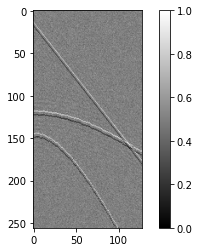

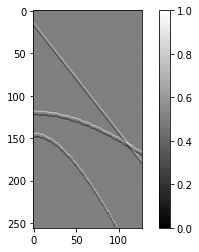

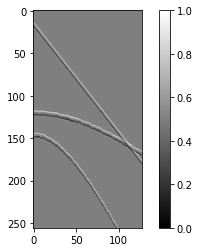

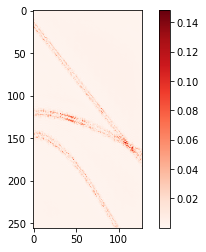

In [15]:
# Perform a sanity check on some random validation samples

ix = random.randint(0, len(preds_test)-1)

# for ix in range(len(preds_test)):
#     print(ix)
#     print(abs(np.array([Y_test[ix,:,:] - preds_test[ix,:,:]])).max())
    
plt.imshow(X_test[ix,:,:], cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.imshow(Y_test[ix,:,:], cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.imshow(preds_test[ix,:,:], cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.imshow(abs(Y_test[ix,:,:] - preds_test[ix,:,:]),cmap = 'Reds')
plt.colorbar()
# plt.clim(0,0.05)
plt.show()



In [16]:
from numpy import savetxt

for ix in range(len(preds_test)):
    savetxt("XDataTest/" + 'X_' + str(ix+1) + '.txt',np.squeeze(X_test[ix,:,:]), delimiter=',')
    savetxt("YDataTest/" + 'Y_' + str(ix+1) + '.txt',np.squeeze(Y_test[ix,:,:]), delimiter=',')
    savetxt("ZDataTest/" + 'Z_' + str(ix+1) + '.txt',np.squeeze(preds_test[ix,:,:]), delimiter=',')
    print(str(ix))
    
#     print(np.squeeze(preds_test[ix,:,:]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# sampling frequency = 4 - get a magnitude spectrum
plt.plot(scipy.signal.freqz(X_test[ix,:,1].flatten()))

# display the plots

plt.show()